# Fundamentos de Robótica
## Exercício 7
### Danilo Calhes Paixão dos Santos - 11025215

Para o sétimo exercício, podemos iniciar a modelagem do problema por meio do Exercício 1 presente nos slides da [aula 5](https://drive.google.com/file/d/1v4PbbCAe42oTv72AwB6EN4Gj01qhHU-V/view), visto que a estrutura do robo é semelhante à presente no Exercício 3. 

## Exercicio 1
O robô é definido pela estrutura abaixo.
<img src=./Exercicio_7/img/ex1.png>
Ao obter as equações do ponto $x$ e $y$ do robô, obtemos as seguintes equações:
$$x = a_1 \cos(\theta_1)+a_2 \cos(\theta_1+\theta_2)$$
$$y = a_1 \sin(\theta_1)+a_2 \sin(\theta_1+\theta_2)$$
Por meio de algumas transformações, obtemos então as seguintes equações para as soluções de variáveis de junta:
$$\theta_1 = \arctan\left(\frac{y(a_1 + a_2\cos{\theta_2}) - x\cdot a_2\sin{\theta_2}}{x(a_1 + a_2\cos\theta_2) + y\cdot a_2\sin\theta_2} \right)$$
$$\theta_2 =\pm\arccos\left(\frac{x^2+y^2-a_1^2-a_2^2}{2a_1a_2}\right)$$
Dessa maneira, podemos definir funções em Python com o auxilio da biblioteca _numpy_ que calculam estas soluções com base nos parâmetros determinados:

In [255]:
import numpy as np
def getTheta1(x,y,a1=1,a2=1,theta2=0):
    u = y*(a1 + a2*np.cos(theta2)) - x*a2*np.sin(theta2)
    d = x*(a1 + a2*np.cos(theta2)) + y*a2*np.sin(theta2)
    theta1 = np.arctan(u/d)
    return theta1

def getTheta2(x,y,a1=1,a2=1):
    u = np.square(x)+np.square(y)-np.square(a1)-np.square(a2)
    d = 2.*a1*a2
    theta2 = np.arccos(u/d)
    return [+theta2,-theta2]

def getThetas(x,y,a1=1,a2=1,unit='deg'):
    values = []
    theta2 = getTheta2(x,y,a1,a2)
    for tht2 in theta2:
        tht1 = getTheta1(x,y,a1,a2,tht2)
        if(unit=='rad'): values.append({"theta_1":tht1,"theta_2":tht2})
        else: values.append({"theta_1":np.degrees(tht1),"theta_2":np.degrees(tht2)})
    return values

Definimos também a tabela de Denavit-Hartenberg, que se apresenta a seguir:

|Junta| a | $\alpha$ | d   | $\theta$ |
|---|---|-------|-----|-------|
| 1 | $a_1$ | 0   | 0 | $^*$$\theta_1$     |
| 2 | $a_2$ | 0    | 0 | $^*$$\theta_2$   |

### Item A
Para o **item a** a tabela de Denavit-Hartenberg é posta da seguinte maneira:

|Junta| a | $\alpha$ | d   | $\theta$ |
|---|---|-------|-----|-------|
| 1 | 1 | 0   | 0 | $^*$$\theta_1$     |
| 2 | 1 | 0    | 0 | $^*$$\theta_2$   |

Por meio das bibliotecas desenvolvidas para a Atividade 5, podemos obter as matrizes de transformação $A^i_{i-1}$:
$$A^i_{i-1} = Rot_z(\theta)Trans_z(d)Trans_x(a)Rot_x(\alpha)$$

$$A^i_{i-1} = \begin{bmatrix}
 c_{\theta_i} & -s_{\theta_i}c_{\alpha_i} & s_{\theta_i}s_{\alpha_i} &  a_i c_{\theta_i}\\ 
 s_{\theta_i} &  c_{\theta_i}c_{\alpha_i}& -c_{\theta_i}s_{\alpha_i} & a_i s_{\theta_i}\\ 
 0 & s_{\alpha_i} & c_{\alpha_i} & d_i\\ 
 0 & 0  & 0 & 1
\end{bmatrix}$$

In [257]:
import numpy as np
import pandas as pd
import os
def getElementarMatrix(a,alpha,d,theta):
    c_theta = np.cos(np.radians(theta))
    s_theta = np.sin(np.radians(theta))
    c_alpha = np.cos(np.radians(alpha))
    s_alpha = np.sin(np.radians(alpha))

    matrix = np.array([
        [c_theta,-s_theta*c_alpha,s_theta*s_alpha,a*c_theta],
        [s_theta,c_theta*c_alpha,-c_theta*s_alpha,a*s_theta],
        [0,s_alpha,c_alpha,d],
        [0,0,0,1]
    ])
    return matrix

def getConfiguration(dh_mat,folder='results',name='mat',convert=[''],verbose=False,save=False):
    if(verbose): printDHmatrix(dh_mat)
    if(len(convert)>0):
        convertDHmatrix(dh_mat,folder=folder,name=name,types=convert,save=save)
    
    joints = dh_mat.shape[0]
    if(verbose): print("+==== No. of joints: ",joints)
    configs = []
    for joint,props in enumerate(dh_mat):
        if(verbose): print("+== Joint {}: {}".format(joint+1,props))
        if(verbose): print("A_0{}:\n{}\n".format(joint+1,getElementarMatrix(*np.asarray(props))))
        if(len(convert)>0):
            convertMatrix(dh_mat,folder=folder,name=name+str(joint+1),types=convert,save=save)
        configs.append({"joint":joint+1,
                       "matrix":getElementarMatrix(*np.asarray(props))})
    return configs

def printDHmatrix(dh_matrix):
    DF_mat = pd.DataFrame(dh_matrix, index=range(1,len(dh_matrix)+1), columns=["a","alpha","d","theta"])
    print(DF_mat,"\n")
    
def convertDHmatrix(dh_matrix,verbose=False,types=['latex', 'csv'],folder="",name="mat",save=False):
    if 'latex' in types:
        DF_mat = pd.DataFrame(dh_matrix, index=range(1,len(dh_matrix)+1), columns=["a","alpha","d","theta"])
        latex_output = DF_mat.to_latex()
        if(verbose): print(latex_output)
        if(save):
            filename = open(os.path.join(".",folder,name+"_DHmat.latex"),'w')
            filename.write(latex_output)
            filename.close()
        
    if 'csv' in types:
        DF_mat = pd.DataFrame(dh_matrix, index=range(1,len(dh_matrix)+1), columns=["a","alpha","d","theta"])
        csv_output = DF_mat.to_csv()
        if(verbose): print(csv_output)
        if(save):
            filename = open(os.path.join(".",folder,name+"_DHmat.csv"),'w')
            filename.write(csv_output)
            filename.close()
   # Para python>=3.6.1 com pandas==1.0.1     
   # if 'md' in types:
        #DF_mat = pd.DataFrame(dh_matrix)
        #if(verbose): print(DF_mat.to_markdown())
            
def convertMatrix(dh_matrix,verbose=False,types=['latex', 'csv'],folder="",name="mat",save=False):
    if 'latex' in types:
        DF_mat = pd.DataFrame(dh_matrix)
        latex_output = DF_mat.to_latex()
        if(verbose): print(latex_output)
        if(save):
            filename = open(os.path.join(".",folder,name+"_mat.latex"),'w')
            filename.write(latex_output)
            filename.close()
        
    if 'csv' in types:
        DF_mat = pd.DataFrame(dh_matrix)
        csv_output = DF_mat.to_csv(index=False,header=False) 
        if(verbose):  print(csv_output)
        if(save):
            filename = open(os.path.join(".",folder,name+"_mat.csv"),'w')
            filename.write(csv_output)
            filename.close()
    # Para python>=3.6.1 com pandas==1.0.1    
    #if 'md' in types:
        #DF_mat = pd.DataFrame(dh_matrix)
        #if(verbose): print(DF_mat.to_markdown())

Configurando a tabela de Denavit-Hartenberg para o problema específico temos:

In [90]:
def getDHmatrix(theta_1=-45,
                theta_2=0):
    dh_mat=np.array([
        [ 1 , 0 , 0 , theta_1 ],
        [ 1 , 0 , 0 , theta_2 ]
    ])
    
    return dh_mat

Testamos assim para as variáveis de junta $\theta_1 = 0^\mathrm{o}$ e $\theta_2 = 0^\mathrm{o}$:

++ Matriz homogenea 0
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
++ Matriz homogenea  1
[[1. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
++ Matriz homogenea  2
[[1. 0. 0. 2.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
p0 = (0.0,0.0)
p1 = (1.0,0.0)
p2 = (2.0,0.0)


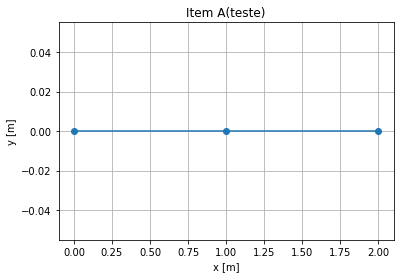

In [264]:
import matplotlib.pyplot as plt
x =[0.0]
y =[0.0]
config_1={"theta_1":0.,
          "theta_2":0.}

dh_matrix= getDHmatrix(**config_1)
configurations = getConfiguration(dh_matrix)
homogen = np.identity(4) #inicializa a matriz identidade

print("++ Matriz homogenea 0")
print(homogen)
for config in configurations:
    print("++ Matriz homogenea ",config['joint'])
    homogen = homogen@config['matrix']
    print(homogen)
    x.append(homogen[0,3])
    y.append(homogen[1,3])

for i,val in enumerate(x):
    print("p{} = ({},{})".format(i,val,y[i]))

plt.plot(x,y,marker='o')
plt.title("Item A(teste)")
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.grid()

E, por fim calculando para as variáveis $\theta_1 = 30^\mathrm{o}$ e $\theta_2 = 45^\mathrm{o}$:

p0 = (0.0,0.0)
p1 = (0.8660254037844387,0.49999999999999994)
p2 = (1.1248444488869596,1.4659258262890682)


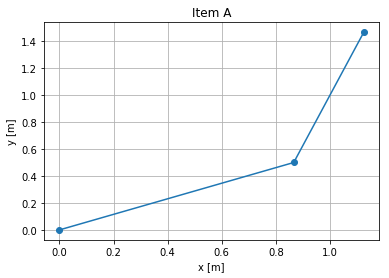

In [267]:
x =[0.0]
y =[0.0]
config_1={"theta_1":30.,
          "theta_2":45.}

dh_matrix= getDHmatrix(**config_1)
configurations = getConfiguration(dh_matrix)
homogen = np.identity(4) #inicializa a matriz identidade
for config in configurations:
    homogen = homogen@config['matrix']
    x.append(homogen[0,3])
    y.append(homogen[1,3])

for i,val in enumerate(x):
    print("p{} = ({},{})".format(i,val,y[i]))

fig = plt.plot(x,y,marker='o')
plt.title("Item A")
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.grid()

As coordenadas obtidas foram:

|Junta| x | y |
|-|-|-|
| Origem | 0.000| 0.000|
| 1 | 0.866 | 0.500 |
| 2 | 1.125 | 1.466 |

Sendo a coordenada do efetuador $(x,y)=(1.125 , 1.466)$.

### Item B
Para o item B utilizaremos as coordenadas obtidas anteriormente e plotaremos as soluções tal como anteriormente realizado:

In [270]:
val_x = x[-1]
val_y = y[-1]
print("(x,y) = ({},{})".format(val_x,val_y))

results = getThetas(a1=1,a2=1,x=val_x,y=val_y)

for solution,res in enumerate(results):
    print("Solution {}:\n  theta1 = {}\n  theta2 = {}".format(solution+1,res['theta_1'],res['theta_2']))

(x,y) = (1.1248444488869596,1.4659258262890682)
Solution 1:
  theta1 = 29.999999999999996
  theta2 = 45.00000000000001
Solution 2:
  theta1 = 75.0
  theta2 = -45.00000000000001


Obitvemos então as seguintes soluções:


|Solução| $\theta_1$ | $\theta_2$ |
|-|-|-|
| 1 | 29.999 $^\mathrm{o}$ | 45.000 $^\mathrm{o}$ |
| 2 | 75.0 $^\mathrm{o}$ | -45.000 $^\mathrm{o}$ |

De maneira gráfica podemos notar a semelhança:

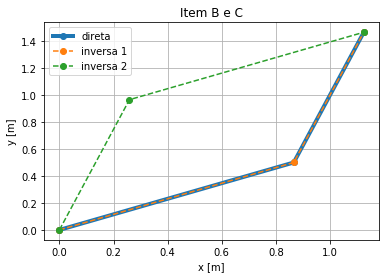

In [271]:
x =[0.0]
y =[0.0]
config_1={"theta_1":30.,
          "theta_2":45.}

configurations = getConfiguration(getDHmatrix(**config_1))
homogen = np.identity(4) #inicializa a matriz identidade
for config in configurations:
    homogen = homogen@config['matrix']
    x.append(homogen[0,3])
    y.append(homogen[1,3])

plt.plot(x,y,marker='o',linewidth=4, label='direta')

for solution,res in enumerate(results):
    x =[0.0]
    y =[0.0]
    configurations = getConfiguration(getDHmatrix(**res))
    homogen = np.identity(4) #inicializa a matriz identidade
    for config in configurations:
        homogen = homogen@config['matrix']
        x.append(homogen[0,3])
        y.append(homogen[1,3])
    plt.plot(x,y,marker='o',linestyle='--',label='inversa {}'.format(solution+1))
plt.legend()
plt.title("Item B e C")
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.grid()

Duas soluções foram encontradas, mas apenas a solução 1 foi semelhante à obtida pelo metodo direto.

## Exercício 3
Para o terceiro exercício, a estrutura do robô é semelhante, exceto pelo fato de que o elo entre a junta 1 e a junta 2 agora é uma junta de tipo prismática.
<img src=./Exercicio_7/img/ex_3.png>

De forma semelhante ao exercício anterior obtemos as soluções para as variáveis de junta por meio das equações:
$$\theta_1 = \arctan\left(\frac{y - a_2\sin{\varphi}}{x- a_2\sin\varphi} \right)$$
$$a_2 = \sqrt{(x - a_2\sin{\varphi})^2+(y - a_2\sin{\varphi})^2}$$
$$\theta_2 =\varphi - \theta_1$$

Assim criamos funções para calcular as soluções:

In [282]:
import numpy as np
def getTheta1(x,y,a2=1,phi=0):
    u = y - a2*np.sin(phi)
    d = x - a2*np.cos(phi)
    theta1 = np.arctan(u/d)
    return theta1

def getA1(x,y,a2=1,phi=0):
    a1 = np.sqrt(np.square(x - a2*np.sin(phi))+np.square(y - a2*np.cos(phi)))
    return a1

def getTheta2(theta1=0,phi=0):
    theta2 = phi-theta1
    return theta2
    
def getSolution(x,y,a2=1,phi=0,unit='deg'):
    values = []
    if(unit=='deg'): phi=np.radians(phi)
    tht1 = getTheta1(x,y,a2,phi)
    a1 = getA1(x,y,a2,phi)
    tht2 = getTheta2(tht1,phi)
    if(unit=='rad'): values.append({"a_1":a1,"theta_1":tht1,"theta_2":tht2})
    else: values.append({"a_1":a1,"theta_1":np.degrees(tht1),"theta_2":np.degrees(tht2)})
    return values

Para cada um dos items, por meio dos pontos descritos na tabela a seguir, é calculada a solução:

|Solução| $P_{ef}$ | $\varphi$ |
|-|-|-|
| A |(1.0,1.0) | 60$^\mathrm{o}$ |
| B |(0.7,0.8) | 30$^\mathrm{o}$ |
| C |(1.0,1.0) | 120$^\mathrm{o}$ |
| D |(0.5,0.5) | -45$^\mathrm{o}$ |

In [283]:
results = []
# Item A
res = getSolution(x=1.,y=1.,a2=.5,phi=60)[0]
item = 'A'
results.append({"item": item,
               "solution":res})
print("Solution {}:\n  a_1 = {}\n  theta1 = {}\n  theta2 = {}".format(item,
                                                                      res['a_1'],
                                                                      res['theta_1'],
                                                                      res['theta_2']))

# Item B
res = getSolution(x=0.7,y=0.8,a2=.5,phi=30)[0]
item = 'B'
results.append({"item": item,
               "solution":res})
print("Solution {}:\n  a_1 = {}\n  theta1 = {}\n  theta2 = {}".format(item,
                                                                      res['a_1'],
                                                                      res['theta_1'],
                                                                      res['theta_2']))
# Item C
res = getSolution(x=1.,y=1.,a2=.5,phi=120)[0]
item = 'C'
results.append({"item": item,
               "solution":res})
print("Solution {}:\n  a_1 = {}\n  theta1 = {}\n  theta2 = {}".format(item,
                                                                      res['a_1'],
                                                                      res['theta_1'],
                                                                      res['theta_2']))
# Item C
res = getSolution(x=.5,y=.5,a2=.5,phi=-45)[0]
item = 'D'
results.append({"item": item,
               "solution":res})
print("Solution {}:\n  a_1 = {}\n  theta1 = {}\n  theta2 = {}".format(item,
                                                                      res['a_1'],
                                                                      res['theta_1'],
                                                                      res['theta_2']))

Solution A:
  a_1 = 0.9401992321926036
  theta1 = 37.08866308098692
  theta2 = 22.911336919013078
Solution B:
  a_1 = 0.5806717463183904
  theta1 = 64.1066053508691
  theta2 = -34.1066053508691
Solution C:
  a_1 = 1.3725795409430963
  theta1 = 24.398561155330487
  theta2 = 95.6014388446695
Solution D:
  a_1 = 0.8660254037844386
  theta1 = 80.26438968275465
  theta2 = -125.26438968275465


Obtendo então as seguintes soluções:

|Solução| a$_1$| $\theta_1$ | $\theta_2$ |
|-|-|-|-|
| A |0.940 |37.089 $^\mathrm{o}$ | 22.911 $^\mathrm{o}$ |
| B |0.581 |64.107 $^\mathrm{o}$ | -34.107 $^\mathrm{o}$ |
| C |1.373 |24.399 $^\mathrm{o}$ | 95.601 $^\mathrm{o}$ |
| D |0.866 |80.264 $^\mathrm{o}$ | -125.264 $^\mathrm{o}$ |

Por fim, para plotar as soluções, criamos a tabela de Denavit-Hartenberg e realizamos o processo utilizado anteriormente.

In [286]:
def getDHmatrix(a_1=1,
                theta_1=-45,
                theta_2=0):
    dh_mat=np.array([
        [ 0 , 0 , 0 , theta_1 ],
        [ a_1 , 0 , 0 , 0 ],
        [ 1 , 0 , 0 , theta_2 ]
    ])
    
    return dh_mat

Os plots são então:

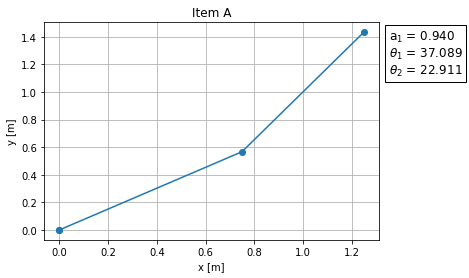

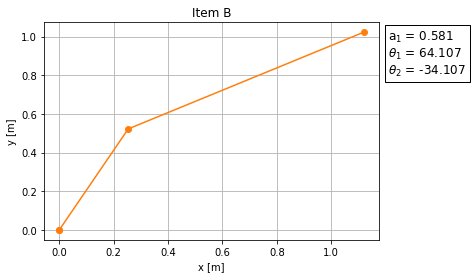

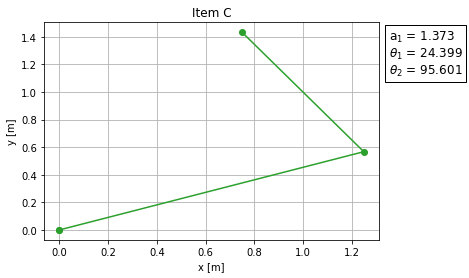

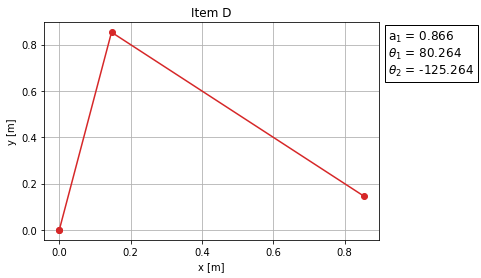

In [290]:
for idx,res in enumerate(results):
    fig = plt.figure()
    item = res["item"]
    solution = res['solution']
    x =[0.0]
    y =[0.0]
    configurations = getConfiguration(getDHmatrix(**solution))
    homogen = np.identity(4) #inicializa a matriz identidade
    for config in configurations:
        homogen = homogen@config['matrix']
        x.append(homogen[0,3])
        y.append(homogen[1,3])
    prop_text="a$_1$"+" = {:.3f}\n".format(solution['a_1'])+\
              r"$\theta_1$"+" = {:.3f}\n".format(solution['theta_1'])+\
              r"$\theta_2$"+" = {:.3f}".format(solution['theta_2'])
    props = dict(boxstyle='square', alpha=1.,facecolor='white')
    plt.plot(x,y,marker='o',label="a",color='C{}'.format(idx))
    plt.title('Item {}'.format(item))
    plt.grid()
    plt.text(plt.xlim()[1]*1.03,plt.ylim()[1]*0.75,prop_text,bbox=props,fontsize=12)
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
